# Credit Risk Analysis Model -Lending Club

# __Model selection and Evaluation__

In [4]:
#import all libraries

import itertools
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from sklearn import datasets

from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,auc,average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

from mlxtend.plotting import plot_learning_curves
from mlxtend.plotting import plot_decision_regions

In [5]:
#upload the data with out Grade
data=pd.read_csv('../.../../Capstone Project/data_without_dummy.csv')

In [6]:
data

,Loan Amount,Term,Interest Rate,Installment,Grade,Sub Grade,Employee Length,Home Ownership,Annual Income,Verification Status,...,Fico Range Low,Fico Range High,Open Acc,Pub Rec,Revol Bal,Revol Util,Total Acc,Application Type,Mortagage Account,Pub Rec Bankruptcies
0,17000.0,0,19.03,623.42,D,D3,1,MORTGAGE,105000.00,Not Verified,...,675.0,679.0,19.0,0.0,14878.0,26.3,37.0,0,1.0,0.0
1,12000.0,0,7.97,375.88,A,A5,10,MORTGAGE,115000.00,Not Verified,...,705.0,709.0,7.0,0.0,2125.0,27.6,14.0,0,3.0,0.0
2,30950.0,0,24.85,1228.12,E,E3,10,RENT,80000.00,Verified,...,695.0,699.0,19.0,0.0,18571.0,37.4,32.0,0,0.0,0.0
3,8000.0,0,13.59,271.84,C,C2,2,MORTGAGE,90000.00,Not Verified,...,660.0,664.0,22.0,0.0,13340.0,46.0,25.0,0,2.0,0.0
4,20000.0,1,19.03,519.15,D,D3,0,MORTGAGE,35000.00,Not Verified,...,665.0,669.0,10.0,0.0,1746.0,12.6,15.0,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73878,35175.0,0,17.09,1255.67,D,D1,10,MORTGAGE,100000.00,Verified,...,680.0,684.0,13.0,0.0,36862.0,75.5,29.0,1,5.0,0.0
73879,7400.0,0,17.09,264.17,D,D1,1,MORTGAGE,49900.00,Source Verified,...,660.0,664.0,13.0,0.0,5422.0,25.3,34.0,0,3.0,0.0
73880,20000.0,0,12.62,670.23,C,C1,10,OWN,50000.00,Not Verified,...,700.0,704.0,12.0,0.0,7966.0,28.7,16.0,0,0.0,0.0
73881,12000.0,1,12.62,270.71,C,C1,0,MORTGAGE,89625.39,Not Verified,...,660.0,664.0,10.0,0.0,18601.0,90.3,37.0,0,1.0,0.0


In [11]:
grade_dict={'A':1.,'B':2.,'C':3.,'D':4.,'E':5.,'F':6.,'G':7.,'None':np.nan}
data['Grade']=data["Grade"].apply(grade_dict.get)

# Baseline model

In [12]:
# set target varibale and independent variable
y=data['Loan Status']
x=data[['Grade']]


# Balancing oversampling dataset

In [13]:
#using SMOTE function to balancing the data
from imblearn.over_sampling import SMOTE

sm = SMOTE()
x,y = sm.fit_resample(x, y)


In [14]:
print(f'oversample length of x : {len(x)}')
print(f'oversample length of x : {len(y)}')

oversample length of x : 105870
oversample length of x : 105870


In [15]:
#Target balanced
y.value_counts()

1    52935
0    52935
Name: Loan Status, dtype: int64

# Define Base line features

In [16]:
print(x.shape)
print(y.shape)

(105870, 1)
(105870,)


In [17]:
#split the data
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=1234)
print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)

(84696, 1) (21174, 1) (84696,) (21174,)


In [18]:
#standralised the data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test=sc.transform(x_test)

In [19]:
#define the function for print the score
def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        print("Train Result:\n")
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_train, clf.predict(X_train))))
        print("Classification Report: \n {}\n".format(classification_report(y_train, clf.predict(X_train))))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_train, clf.predict(X_train))))

        res = cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy')
        print("Average Accuracy: \t {0:.4f}".format(np.mean(res)))
        print("Accuracy SD: \t\t {0:.4f}".format(np.std(res)))
    elif train==False:
        print("Test Result:\n")        
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_test, clf.predict(X_test))))
        print("Classification Report: \n {}\n".format(classification_report(y_test, clf.predict(X_test))))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_test, clf.predict(X_test))))

__Logistic Regression as Baseline model__

In [20]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(C = 0.0001,random_state=21)

log_reg.fit(x_train, y_train)

LogisticRegression(C=0.0001, random_state=21)

In [21]:
from sklearn.metrics import classification_report
print_score(log_reg, x_train, y_train, x_test, y_test, train=False)

Test Result:

accuracy score: 0.6139

Classification Report: 
               precision    recall  f1-score   support

           0       0.67      0.44      0.53     10569
           1       0.59      0.79      0.67     10605

    accuracy                           0.61     21174
   macro avg       0.63      0.61      0.60     21174
weighted avg       0.63      0.61      0.60     21174


Confusion Matrix: 
 [[4657 5912]
 [2264 8341]]



Accuracy is:  0.6138660621516955
              precision    recall  f1-score   support

           0       0.67      0.44      0.53     10569
           1       0.59      0.79      0.67     10605

    accuracy                           0.61     21174
   macro avg       0.63      0.61      0.60     21174
weighted avg       0.63      0.61      0.60     21174



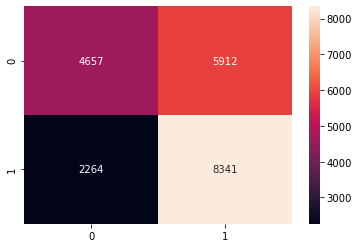

In [22]:
#logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report
lg_model=LogisticRegression()
lg_model.fit(x_train,y_train)
score=lg_model.score(x_test,y_test)


y_pred=lg_model.predict(x_test)
log_ac = accuracy_score(y_test,y_pred)
print('Accuracy is: ',log_ac)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm,annot=True,fmt="d");
print(classification_report(y_test, y_pred))